## Predição de Fraudes "Card Not Present" (IEEE-CIS Dataset)

O problema escolhido para realização do projeto foi de fraudes em transações sem cartão presencial, conhecidas como **"Card Not Present Fraud"**. Os dados foram preparados e disponibilizados pela IEEE Computational Intelligence Society e lançados durante uma competição [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection/overview) no Kaggle.

O que torna esse projeto mais interessante é que os dados são de **transações reais** foram fornecidos pela [Vesta Corporation](https://vesta.io/). A Vesta é uma empresa especializada em soluções de proteção contra fraudes e processamento de pagamentos para transações móveis e online. A empresa utiliza modelos avançados de *machine learning* para analisar mais de US$ 4 bilhões em transações anualmente, fornecendo serviços que permitem a aprovação de vendas em milissegundos e o processamento de pagamentos em mais de 40 países.

O conjunto de dados possui cerca de 600.000 registros e contém mais de 430 características. Portanto, além do desafio de modelagem para predição de fraudes, é preciso considerar o grande volume de dados e a alta dimensionalidade. Por serem transações reais, um grande número de *features* foram anonimizadas, garantindo a privacidade dos clientes, portanto, não é possível saber qual o conteúdo real de todas as variáveis.

### Definição do problema

Imagine a seguinte situação. Você compra um café da manhã na padaria e se dirige ao caixa para pagar. Como é muito comum nos tempos atuais, você utiliza seu telefone para pagar, usando um cartão digital por aproximação, mas sua compra é negada. Ou você decide aproveitar as promoções de fim de ano em determinada plataforma de e-commerce, preenche as informações do seu cartão, mas sua compra não pode ser efetuada.

Embora você tenha certeza que possui dinheiro suficiente para realizar a compra, por algum motivo sua transação não é efetuada. Isso acontece por que, todos os anos, mais de 30 bilhões de dólares são movimentados em transações fraudulentas de cartões de crédito e as empresas envolvidas nesses serviços, como bancos, instituições de pagamento e prestadoras de serviço, investem pesado em **sistemas de prevenção de fraude**. Apesar de nem sempre serem acertivos, como no caso descrito acima quando houve uma falso positivo, esses sistema podem evitar uma grande dor de cabeça para os clientes e para essas instituições.

A fraude em transações "Card Not Present" (CNP) ocorre quando compras são realizadas sem a presença física do cartão. Com o avanço da tecnologia e a popularização das compras pela internet, esse tipo de transação tornou-se predominante. No Brasil, por exemplo, 61% dos consumidores preferem comprar online em vez de em lojas físicas, e 78% realizam pelo menos uma compra mensal pela internet. Nessas compras, os consumidores inserem os dados do cartão, como número, data de validade e código de segurança, ou utilizam carteiras digitais em dispositivos móveis, facilitando as transações, mas também aumentando os riscos de fraude.

Considerando esse cenário, o objetivo do trabalho é criar um **modelo de classificação** capaz de estimar a probabilidade das trações serem verdadeiras ou fraudes. Em paralelo, também discutir conceitos importantes desse tipo de problema, como classes desbalanceadas, redução de dimensionalidade e uso adequado de métricas.

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# sklearn utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, precision_score, recall_score, f1_score

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# other ml tools
from lightgbm import LGBMClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Análise Exploratória de Dados

Como discutido, neste problema vamos criar um classificador para prever a probabilidade de uma transação ser fraudulenta, indicada pelo alvo binário `isFraud`. Os dados de treinamento do Kaggle estão divididos em dois arquivos, `train_identity.csv` e `train_transaction.csv`, que são unidos pela chave `TransactionID`.

Por ser uma competição, o Kaggle não permite baixar os arquivos sem fazer login, por isso, não foi possível ler os dados através da URL. Foi necessário baixar os arquivos, que podem ser encontrados na pasta `/data` e ler localmente. 

#### Identity

In [3]:
train_identity = pd.read_csv('data/train_identity.csv')
train_identity.shape

(144233, 41)

In [4]:
train_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
identity_columns = train_identity.columns.difference(['TransactionID'])

#### Transaction

Por causa do grande volume de *features* nos dados de transações (394), vamos ler os dados em *chunks* ou blocos de 100.000 registros, o que otimiza a alocação de memória da máquina. Após concatenar os blocos em um único DataFrame, podemos deletar esses blocos para economizar recursos.

In [7]:
transaction_chunks = pd.read_csv('data/train_transaction.csv', chunksize=10 ** 5)
train_transaction = pd.concat(transaction_chunks)

train_transaction.shape

(590540, 394)

In [8]:
train_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
del transaction_chunks

In [ ]:
associated = np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique()))
total_transaction = train_transaction.shape[0]

pct_records = np.divide(associated, total_transaction) * 100

print(f'{pct_records:.2f}% dos registros em "Transaction" ({total_transaction}) possuem registros de "Identity" associados.')

24.42% do registro em Transaction (590540) possuem registros de Identity associados.


#### isFraud

Em alguns casos específicos de modelagem preditiva, lidamos com um problema conhecido como “classes desbalanceadas”. Isso acontece quando queremos classificar determinado exemplo, seja em tarefas binárias ou de múltiplas classes, mas os dados de treinamento específicos não apresentam uma distribuição equilibrada dessas classes. Vamo verificar se esse é o caso em nosso conjunto de dados:

In [11]:
train_transaction['isFraud'].value_counts(normalize=True).round(4) * 100

isFraud
0    96.5
1     3.5
Name: proportion, dtype: float64

Em problemas de detecção de fraudes, assim como predição de CHURN ou doenças raras, o fenômeno que queremos prever, geralmente, é subrepresentado nos dados de treino. Como podemos ver, isso aconte em nosso conjunto de dados, uma vez que apenas 3,5% do dados de treino são positivos para fraude.

Quando há desbalanceamento de classes é necessário conhecer algumas técnicas para lidar com esse problemas de forma eficiente, que pode ser abordado pela via da reamostragem, buscando equilibrar as classes removendo exemplos da classe majoritária ou criando exemplos artificiais da classe minoritária. Outra abordagem é o uso correto de métricas de avaliação.

A acurácia é uma métrica muito usada em problemas gerais, mas que não tem grande utilidade para esse problema específico. Imagine que o modelo aprenda a dizer que todas as transações são verdadeiras, a acurácia seria próxima de 97%, mas nosso modelo seria muito ruim. Métricas mais adequadas são a **precisão** e o **recall**, que juntas formam o **F1 score**.

Essa métricas são calculadas apartir do número de falsos positivos ou falsos negativos e do verdadeiros positivos. Assim, podemos ajustar nosso modelo mais adequadamente para nosso objetivo alvo: minimizar falsos positivos (recall) ou minimizar falsos negativos (precisão). Vamos discutir essas técnicas mais profundamente ao longo do trabalho.

#### TransactionAmt

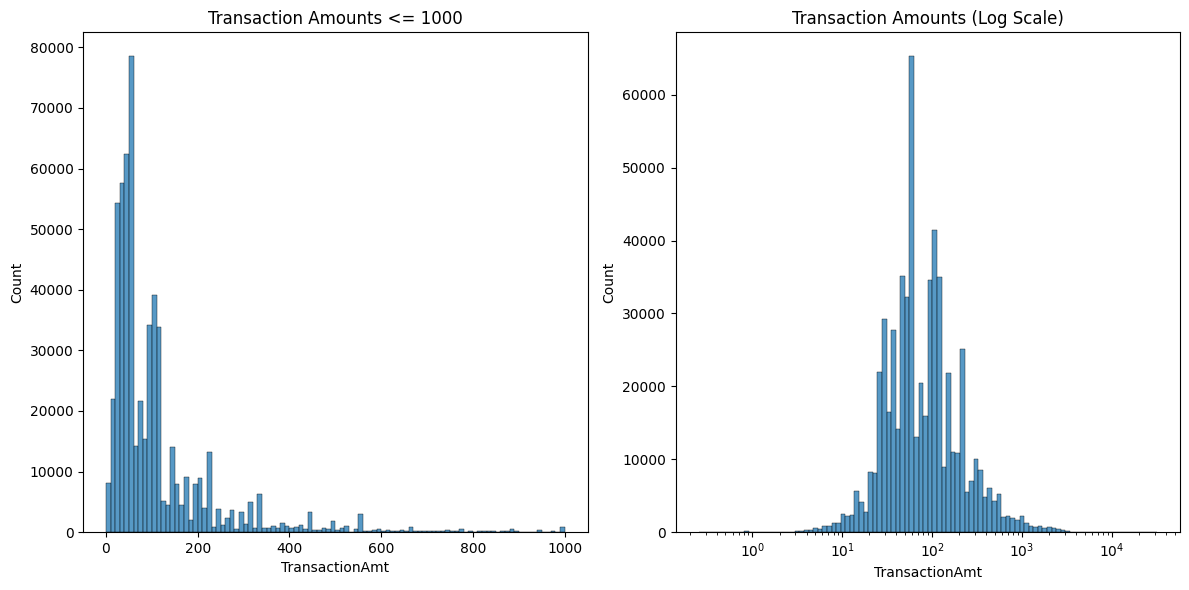

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=False)

ax1.set_title('Transaction Amounts <= 1000')
ax2.set_title('Transaction Amounts (Log Scale)')

sns.histplot(train_transaction.loc[train_transaction['TransactionAmt'] <= 1000], x='TransactionAmt', bins=100, ax=ax1)
sns.histplot(train_transaction, x='TransactionAmt', bins=100, log_scale=True, ax=ax2)

plt.tight_layout()
plt.show()

A análise dos valores de transações revela uma distribuição altamente concentrada em valores baixos, com a maioria das transações ocorrendo abaixo de 200. Essa característica aponta para um desbalanceamento nos dados, com uma pequena proporção de transações de valores significativamente altos. Em termos de modelagem de machine learning, isso implica na necessidade de estratégias específicas para lidar com a amplitude dos dados e a presença de outliers. Transformações, como o uso de escalas logarítmicas, podem ser úteis para estabilizar a variância e melhorar o desempenho de modelos sensíveis à escala. 

Além disso, a predominância de transações de baixo valor sugere que os modelos podem precisar de ajustes para evitar vieses que priorizem padrões comuns e negligenciem a detecção de eventos raros, como fraudes em transações de valores elevados. Avaliar o impacto dessas transações menos frequentes será crucial para garantir que o modelo seja robusto e eficaz em diferentes cenários.

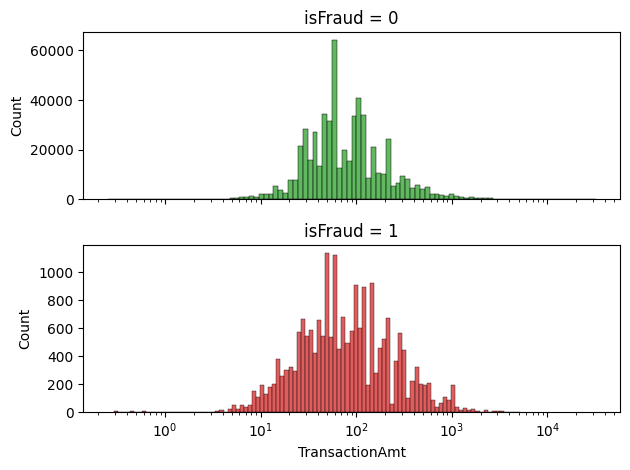

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.set_title('isFraud = 0')
ax2.set_title('isFraud = 1')

sns.histplot(train_transaction.loc[train_transaction['isFraud'] == 0], x='TransactionAmt', color='tab:green', bins=100, log_scale=True, ax=ax1)
sns.histplot(train_transaction.loc[train_transaction['isFraud'] == 1], x='TransactionAmt', color='tab:red', bins=100, log_scale=True, ax=ax2)

plt.tight_layout()
plt.show()

In [19]:
fraud = train_transaction['isFraud'] == 1

mean_fraud = np.mean(train_transaction.loc[fraud, 'TransactionAmt'])
mean_not_fraud = np.mean(train_transaction.loc[~fraud, 'TransactionAmt'])

print(f"Valor médio por transações isFraud == 1 é {mean_fraud:.2f}")
print(f"Valor médio por transações isFraud == 0 é {mean_not_fraud:.2f}")

Valor médio por transações isFraud == 1 é 149.24
Valor médio por transações isFraud == 0 é 134.51


A análise dos dados revela que transações fraudulentas possuem, em média, valores ligeiramente superiores às transações não fraudulentas (149,24 contra 134,51). No entanto, essa diferença de médias é relativamente pequena, e as distribuições de valores para ambos os casos mostram uma sobreposição significativa. Isso indica que o valor da transação, isoladamente, não é um bom discriminador para identificar fraudes.

Apesar disso, o valor da transação pode ser uma variável útil quando combinado com outros fatores, já que existe uma leve tendência de fraudes ocorrerem em transações com valores mais elevados. Para maximizar sua utilidade em um modelo de machine learning, seria interessante explorar interações com outras variáveis, realizar transformações como escalas logarítmicas e investigar a influência de outliers.

#### Card Issuer

In [20]:
train_transaction['card4'].value_counts(dropna=False)

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64

In [21]:
pct_card_fraud = train_transaction.groupby(['card4', 'isFraud'])['TransactionAmt'].sum() / train_transaction.groupby(['card4'])['TransactionAmt'].sum()
pct_card_fraud = (pct_card_fraud * 100).unstack(level=0).reset_index(drop=True)

pct_card_fraud

card4,american express,discover,mastercard,visa
0,97.030419,89.702981,96.583877,96.100993
1,2.969581,10.297019,3.416123,3.899007


#### Transaction Type

In [22]:
train_transaction['card6'].value_counts(dropna=False)

card6
debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: count, dtype: int64

#### DeviceType

In [23]:
train_identity['DeviceInfo'].unique()

array(['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

In [24]:
train_identity['DeviceType'].value_counts(dropna=False)

DeviceType
desktop    85165
mobile     55645
NaN         3423
Name: count, dtype: int64

#### E-mail Domain

In [25]:
train_transaction['R_emaildomain'].value_counts(dropna=False)

R_emaildomain
NaN                453249
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
                    ...  
frontiernet.net        14
netzero.com            14
centurylink.net        12
netzero.net             9
sc.rr.com               8
Name: count, Length: 61, dtype: int64

In [26]:
pct_email_fraud = train_transaction.groupby(['R_emaildomain', 'isFraud'])['TransactionAmt'].sum() / train_transaction.groupby(['R_emaildomain'])['TransactionAmt'].sum()
pct_email_fraud = (pct_email_fraud * 100).unstack('isFraud').dropna()

pct_email_fraud.sort_values(by=1, ascending=False).head(10)

isFraud,0,1
R_emaildomain,,
protonmail.com,2.402264,97.597736
mail.com,48.574506,51.425494
netzero.net,55.645161,44.354839
icloud.com,78.613555,21.386445
outlook.com,80.013195,19.986805
outlook.es,84.345394,15.654606
gmail.com,84.677812,15.322188
earthlink.net,85.056705,14.943295
live.com.mx,90.093109,9.906891


### Análise de Componentes Principais (PCA)

In [28]:
merged_chunks = []
transaction_chunks = pd.read_csv('data/train_transaction.csv', chunksize=10 ** 5)

for chunk in transaction_chunks:
    new_chunk = chunk.merge(train_identity, on='TransactionID', how='left')
    merged_chunks.append(new_chunk)

train = pd.concat(merged_chunks)
train = train.groupby('isFraud', group_keys=False)[train.columns].apply(lambda x: x.sample(frac=0.1))

train.shape

(59054, 434)

In [29]:
del train_identity, transaction_chunks

In [30]:
X_train = train.loc[:, train.columns.str.startswith('V')]

print(f'Número de features escolhidas: {X_train.shape[1]}')

Número de features escolhidas: 339


In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train_transformed = numeric_transformer.fit_transform(X_train)

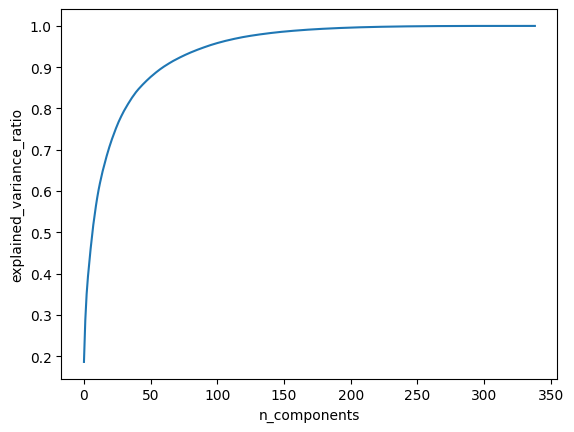

In [32]:
pca = PCA()
pca.fit(X_train_transformed)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("n_components")
plt.ylabel("explained_variance_ratio")

plt.show()

In [33]:
target_variance_ratio = 0.95
d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_variance_ratio) + 1

print(f"Número de dimensões para manter {target_variance_ratio*100}% da variância: {d}")

Número de dimensões para manter 95.0% da variância: 93


### Feature Engineering

In [34]:
train['hasIdentity'] = (train[identity_columns].isna().all(axis=1) == False).astype(int)

In [37]:
train['hasIdentity'].value_counts(normalize=True)

hasIdentity
0    0.757832
1    0.242168
Name: proportion, dtype: float64

In [ ]:
train.loc[~train['card6'].isin(['credit', 'debit']), 'card6'] = np.nan

train['card6'].value_counts(dropna=False)

In [45]:
amount = 'TransactionAmt'
selected_cols = ['card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1']

for col in selected_cols:
    train[f'amount_mean_{col}'] = train[amount] / train.groupby([col])[amount].transform('mean')
    train[f'amount_std_{col}'] = train[amount] / train.groupby([col])[amount].transform('std')

train['TransactionAmtLog'] = np.log(train[amount])
train['TransactionAmtCents'] = (train[amount] - np.floor(train[amount])).astype(np.float64)

In [49]:
train['amount_mean_card6']

43245    0.309440
72318    2.847375
76774    0.747542
45185    0.416482
49460    1.788826
           ...   
35902    1.453436
43548    0.533978
33216    0.384464
20693    1.788826
60167    0.078571
Name: amount_mean_card6, Length: 59054, dtype: float64

In [50]:
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')

train['Date'] = train['TransactionDT'].apply(lambda dt: start_date + timedelta(seconds=dt))

train['Weekday'] = train['Date'].dt.dayofweek
train['Day'] = train['Date'].dt.day
train['Hour'] = train['Date'].dt.hour

train = train.drop(columns=['Date'])

In [52]:
train[['TransactionDT', 'Weekday', 'Day', 'Hour']].sample(5)

,TransactionDT,Weekday,Day,Hour
81509,1743162,4,21,4
15845,2239714,2,26,22
4712,13212379,3,2,22
45635,8532661,5,9,18
4469,4672872,3,24,2


In [53]:
train.shape

(59054, 452)

### Pré-processamento

Categorical Features (Transaction)

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Categorical Features (Identity)

- DeviceType
- DeviceInfo
- id_12 - id_38

Categorical Created Features

- hasIdentity
- Weekday
- Day
- Hour

In [61]:
CAT_FEATURES = [
    *[f'card{i}' for i in range(1, 7)],
    *[f'M{i}' for i in range(1, 10)],
    *[f'id_{i}' for i in range(12, 39)],
    "ProductCD",
    "addr1", 
    "addr2",
    "P_emaildomain",
    "R_emaildomain",
    "DeviceType",
    "DeviceInfo",
    "hasIdentity",
    "Weekday",
    "Day",
    "Hour",
]

In [55]:
X = train.drop(columns=['isFraud'])
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

print(X_train.shape)
print(y_train.shape)

(41337, 451)
(41337,)


In [56]:
X_train = X_train.replace([np.inf, -np.inf], -999)
X_test = X_test.replace([np.inf, -np.inf], -999)

In [62]:
pca_features = X_train.columns[X_train.columns.str.startswith('V')]
cat_features = np.unique(CAT_FEATURES + X_train.select_dtypes(include=['object']).columns.tolist())
num_features = [col for col in X_train.columns if col not in cat_features and col not in pca_features]

print(np.sum(list(map(len, [pca_features, cat_features, num_features]))))

451


In [63]:
categorical_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(lambda X: X.astype(str))),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pca_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=90))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
        ('num', numeric_transformer, num_features),
        ('pca', pca_transformer, pca_features)
    ],
    remainder='passthrough'
)

In [64]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [65]:
del X_train, X_test

### Seleção de modelos

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_transformed, y_train)

y_pred = decision_tree.predict(X_test_transformed)
y_pred.shape

In [67]:
train_score = decision_tree.score(X_train_transformed, y_train)
test_score = decision_tree.score(X_test_transformed, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Train score: 1.0
Test score: 0.9389287125359824


In [68]:
confusion_matrix(y_test, y_pred)

array([[16399,   698],
       [  384,   236]])

In [69]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.6699096427028322
Precision: 0.25267665952890794
Recall: 0.38064516129032255
F1 Score: 0.30373230373230375


In [71]:
results = {}

k_folds = 10
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

models = {
    'LGBM': LGBMClassifier(verbose=-1, random_state=23),
    'RF': RandomForestClassifier(random_state=23),
    'BC': BaggingClassifier(random_state=23),
    'DT': DecisionTreeClassifier(random_state=23),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
    results[name] = scores

    print(f'{name}: {scores.mean()} ({scores.std()})')

LGBM: 0.8938485249599065 (0.010236426835662445)
RF: 0.8707705701322161 (0.017985782932042622)
BC: 0.7994909193050889 (0.017896407547398185)
DT: 0.667541772863737 (0.02226332630831636)


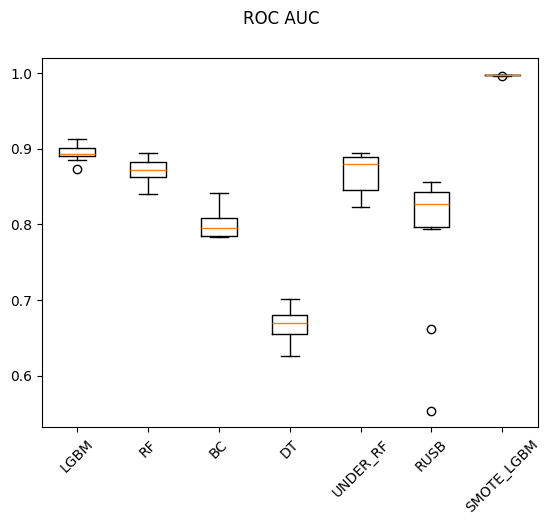

In [88]:
fig = plt.figure()
fig.suptitle('ROC AUC')

ax = fig.add_subplot(111)
plt.boxplot(results.values())

ax.set_xticks(range(1, len(results.keys()) + 1))  # 1-based tick positions
ax.set_xticklabels(results.keys(), rotation=45)  # Use keys as x-axis labels

plt.show()


In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(RandomForestClassifier(random_state=23), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'UNDER_RF: {scores.mean()} ({scores.std()})')

results['UNDER_RF'] = scores

UNDER_RF: 0.868443321442727 (0.025817542915213883)


In [ ]:
rus_boost = RUSBoostClassifier(random_state=23)

scores = cross_val_score(rus_boost, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
print(f'RUSB: {scores.mean()} ({scores.std()})')

results['RUSB'] = scores

RUSB: 0.785819965610141 (0.09398456107895155)


In [76]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(LGBMClassifier(random_state=23, verbose=-1), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'SMOTE_LGBM: {scores.mean()} ({scores.std()})')

results['SMOTE_LGBM'] = scores

SMOTE_LGBM: 0.9971044435064174 (0.0005655883006236095)


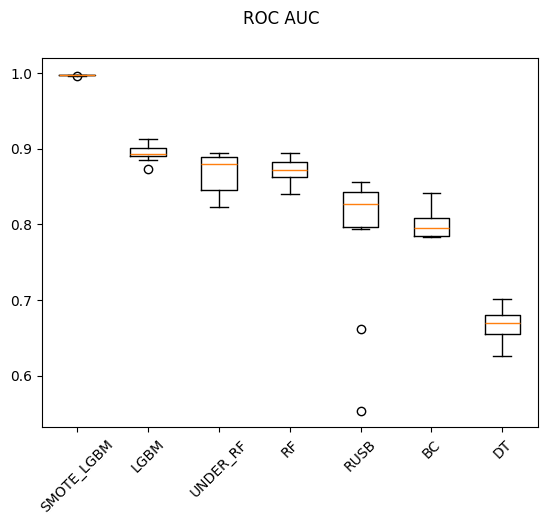

In [87]:
sorted_results = dict(sorted(results.items(), key=lambda x: np.median(x[1]), reverse=True))

fig = plt.figure()
fig.suptitle('ROC AUC')

ax = fig.add_subplot(111)
plt.boxplot(sorted_results.values())

ax.set_xticks(range(1, len(sorted_results.keys()) + 1))
ax.set_xticklabels(sorted_results.keys(), rotation=45)

plt.show()

### Treinamento

#### Under Bagging

In [ ]:
clf = RandomForestClassifier(random_state=23)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=23)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

In [90]:
confusion_matrix(y_test, y_pred)

array([[13330,  3767],
       [  131,   489]])

In [91]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.7841893125939845
Precision: 0.11489661654135339
Recall: 0.7887096774193548
F1 Score: 0.20057424118129613


#### SMOTE Bagging

In [92]:
clf = RandomForestClassifier(random_state=23)
smote = SMOTE(sampling_strategy='minority', random_state=23)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

In [93]:
confusion_matrix(y_test, y_pred)

array([[17021,    76],
       [  369,   251]])

In [94]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.7001967426845306
Precision: 0.7675840978593272
Recall: 0.40483870967741936
F1 Score: 0.5300950369588173


#### Adjusted Weights Random Forest

In [95]:
clf = RandomForestClassifier(class_weight='balanced', random_state=23)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)

In [96]:
confusion_matrix(y_test, y_pred)

array([[17087,    10],
       [  506,   114]])

In [97]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.5916430349033126
Precision: 0.9193548387096774
Recall: 0.18387096774193548
F1 Score: 0.3064516129032258


#### GridSearch

In [98]:
k_folds = 10

param_grid = {
    'max_depth': [30, 50, 60, 90]
}

clf = RandomForestClassifier(n_estimators=100, random_state=23, n_jobs=8)
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', return_train_score=False)
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.9979598033220393
{'max_depth': 30}
RandomForestClassifier(max_depth=30, n_jobs=8, random_state=23)


#### Análise de threshold

In [100]:
y_scores = cross_val_predict(clf, X_train_res, y_train_res, cv=cv, method='predict_proba')

y_scores

array([[0.93, 0.07],
       [0.96, 0.04],
       [0.76, 0.24],
       ...,
       [0.09, 0.91],
       [0.06, 0.94],
       [0.03, 0.97]])

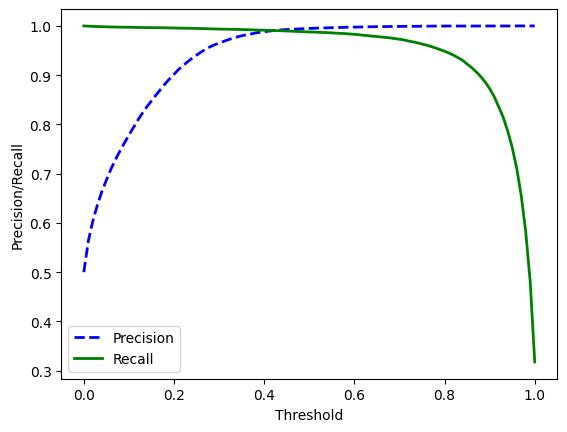

In [101]:
precision, recall, threshold = precision_recall_curve(y_train_res, y_scores[:, 1])

plt.plot(threshold, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshold, recall[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")

plt.show()

In [102]:
print(f'Target threshold to obtain 90% precision is {threshold[np.argmax(precision >= 0.90)]}')
print(f'Target threshold to obtain 90% precision is {threshold[np.argmin(recall >= 0.90)]}')

Target threshold to obtain 90% precision is 0.2
Target threshold to obtain 90% precision is 0.88


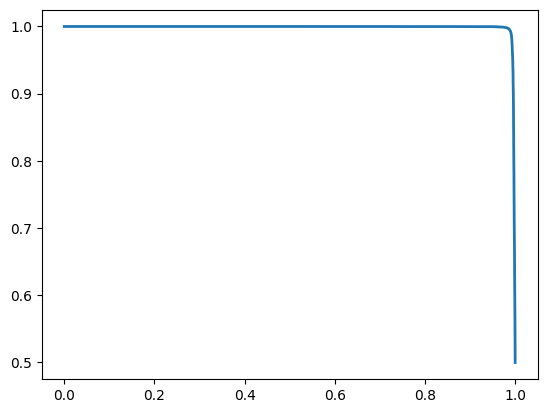

In [103]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")

In [104]:
target_threshold = 0.51

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

y_scores = clf.predict_proba(X_test_transformed)[:, 1]
y_pred = (y_scores >= target_threshold).astype(int)

In [105]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.7001967426845306
Precision: 0.7675840978593272
Recall: 0.40483870967741936
F1 Score: 0.5300950369588173
